# 1. Code from the Network file to define the countries

In [13]:
import requests
import json
import re
import networkx as nx
import numpy as np
import os
from io import StringIO
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
from collections import Counter
import nltk
import pandas as pd

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rital\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
baseurl = "https://en.wikipedia.org/w/api.php?"
action = "action=query"
title = "titles=Member_states_of_the_United_Nations"
content = "prop=revisions&rvprop=content"
dataformat ="format=json"

query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
print(query)

https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&titles=Member_states_of_the_United_Nations&format=json


In [15]:
headers = {"User-Agent" : "MyWikipediaClient/1.0 (example@example.com)"} # just use this dict as-is.
wikiresponse = requests.get(query, headers=headers)
wikidata = wikiresponse.text
dict_data=json.loads(wikidata)

In [16]:
raw_data=dict_data['query']['pages']['31969']['revisions'][0]['*']
raw_data

'{{Short description|none}}\n{{For|the League of Nations|Member states of the League of Nations}}\n{{Featured list}}\n{{pp-pc|small=yes}}\n{{Use dmy dates|date=February 2025}}\n{{Use Oxford spelling|date = February 2025}}\n\n[[File:United Nations (Member States and Territories).svg|thumb|\n{{legend|#009edb|193 United Nations member states}}\n{{legend|#9edb00|2 [[United Nations General Assembly observers#Current non-member observers|UN General Assembly observer states]] (the [[Holy See]]{{efn|The [[sovereignty|sovereign entity]] with [[state (polity)|statehood]] over the territory of the [[Vatican City|Vatican City State]].}} and [[Palestine]])}}\n{{legend|#db9e00|2 non-member states (the [[Cook Islands]] and [[Niue]])<ref>{{Cite web|url = https://www.un.org/en/development/desa/population/publications/pdf/policy/WPP2013/Chapters/a_Preface.pdf |title = UN: "Data for 197 countries: all 193 member states, two observer states (the Holy See and Palestine), and two non-member states (Cook Isl

In [17]:
countries = re.findall(r"\{flag(?:deco|country)?\|([^|}]+)", raw_data)
no_countries = len(countries)
print("Number of countries:", no_countries)

Number of countries: 193


# 2. Reddit API acess

### Test for Portugal to see if its working

In [11]:

url = "https://www.reddit.com/r/history/search.json"
params = {
    "q": "Portugal",
    "limit": 100,
    "sort": "relevance",
    "t": "all",
    "restrict_sr": 1
}

headers = {"User-agent": "Mozilla/5.0"}

response = requests.get(url, params=params, headers=headers)
print(response.status_code)
print(response.text[:500])
data = response.json()

posts = data["data"]["children"]

#print(len(posts))
#print(posts[0]["data"]["title"])


429
<!doctype html>
<html>
  <head>
    <title>Too Many Requests</title>
    <style>
      body {
          font: small verdana, arial, helvetica, sans-serif;
          width: 600px;
          margin: 0 auto;
      }

      h1 {
          height: 40px;
          background: transparent url(//www.redditstatic.com/reddit.com.header.png) no-repeat scroll top right;
      }

      textarea.mushroom {
          display: none
      }
    </style>
  </head>
  <body>
    <h1>whoa there, pardner!</h1>

<p>Re


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [2]:
print(posts[0]["data"].keys())

NameError: name 'posts' is not defined

In [27]:
print(len(posts))

100


In [34]:
print(posts[75]["data"]["selftext"])

The Scramble for Africa only really began in the 1880s.

Sure, there were small exceptions:

 France has outposts in Senegal since the 17th century, Islands (Reunion), Algerian Conquest began in 1830...

Both the Dutch and British started colonizing South Africa earlier. 

Portugal seems to be the only country who began their colonization of Angola and Mozambique quite early (16th century). 

Why did the European Powers (bar Portugal)  get most of their African colonies so late?

Why did they colonise North America, India and Asia so much earlier than Africa, a continent that was right under them!

This especially goes for France (who ended up getting one of the largest chunks): after it lost its colonial empire to Britain at the end of the 7 year war, wouldn't it have been eager to regain it's prestige and rebuild an empire?

Why was most of Africa colonized so late?


### Function to retrieve only posts that are non empty

In [35]:
import requests
import time

headers = {"User-agent": "Mozilla/5.0"}

def fetch_posts(keyword, subreddit=None, limit=100, sort="relevance", t="all"):
    """
    Fetch up to 100 raw Reddit posts for a given keyword/subreddit.
    Does NOT filter empty posts.
    """
    if subreddit:
        url = f"https://www.reddit.com/r/{subreddit}/search.json"
        params = {
            "q": keyword,
            "limit": limit,
            "sort": sort,
            "t": t,
            "restrict_sr": 1
        }
    else:
        url = "https://www.reddit.com/search.json"
        params = {
            "q": keyword,
            "limit": limit,
            "sort": sort,
            "t": t
        }

    try:
        response = requests.get(url, params=params, headers=headers)
        data = response.json()
        return data["data"]["children"]
    except:
        return []


def is_valid_post(post):
    """A post is valid if it has title or selftext not empty."""
    data = post["data"]
    title = data.get("title", "").strip()
    selftext = data.get("selftext", "").strip()

    # Reject ads, promoted posts, empty posts
    if data.get("is_self") is False:
        return False
    
    return (title != "" or selftext != "")


def get_100_valid_posts(keyword, subreddit=None):
    """
    Returns exactly 100 valid posts for a given country query.
    Fetches multiple times until 100 valid posts are collected.
    """
    valid_posts = []
    attempts = 0

    # Multiple strategies to get enough posts
    time_windows = ["all", "year", "month", "week", "day"]
    sorts = ["relevance", "new", "top"]

    while len(valid_posts) < 100:
        attempts += 1
        
        t = time_windows[attempts % len(time_windows)]
        sort = sorts[attempts % len(sorts)]

        print(f"🔎 Attempt {attempts}: sort={sort}, time={t}")

        raw = fetch_posts(keyword, subreddit=subreddit, limit=100, sort=sort, t=t)

        for post in raw:
            if is_valid_post(post):
                valid_posts.append(post)

            if len(valid_posts) == 100:
                break

        # Avoid hammering Reddit
        time.sleep(0.5)

        # Safety check (avoid infinite loops)
        if attempts > 15:
            print("⚠️ Warning: Could not get 100 valid posts. Returning what was found.")
            break

    return valid_posts[:100]


In [36]:
posts = get_100_valid_posts("Portugal", "history")


🔎 Attempt 1: sort=new, time=year
🔎 Attempt 2: sort=top, time=month
🔎 Attempt 3: sort=relevance, time=week
🔎 Attempt 4: sort=new, time=day
🔎 Attempt 5: sort=top, time=all
🔎 Attempt 6: sort=relevance, time=year
🔎 Attempt 7: sort=new, time=month
🔎 Attempt 8: sort=top, time=week
🔎 Attempt 9: sort=relevance, time=day
🔎 Attempt 10: sort=new, time=all


In [38]:
print(len(posts))

100


In [42]:
print(posts[2]["data"]["selftext"])

I thought you guys might like some of the historical illustrations that can be found on /r/papertowns. The countries and cities are listed alphabetically in one of the 5 categories: Europe, Asia &amp; Oceania, The Americas, Middle East &amp; Egypt, Africa. Countries such as Russia, Turkey, Cyprus, Armenia and Georgia are found in the Europe section.

Hope you'll enjoy!

___

**EUROPE**
___

Albania:

* [Buthrotum, antiquity, modern Butrint](https://i.imgur.com/AHywz2Q.jpg)

Armenia:

* [Yerevan, 1672](https://upload.wikimedia.org/wikipedia/commons/f/f6/05_Chardin_Yerevan1672.gif)

Austria:

* [Iuvavum, antiquity, modern Salzburg](https://i.imgur.com/twJsVhG.jpg)

* [Schwaz, 16th century](https://i.imgur.com/JUIDHCl.jpg)

* [Vienna, 1640](https://upload.wikimedia.org/wikipedia/commons/c/ca/Wien_1609_1640_ArM.jpg)

* [Vienna, 1683](https://upload.wikimedia.org/wikipedia/commons/1/1e/Wien-1683%281686%29-Allen-uncroped.jpg)

Belarus:

* [Brest, 17th century](https://i.redd.it/u3y7h1yuuirx.

We will try another way to access Reddit API because this one does not work to get all the data we need. 

In [12]:
import requests

url = "https://api.pullpush.io/reddit/search/submission/"
params = {
    "q": "Portugal",
    "subreddit": "history",
    "size": 100
}

data = requests.get(url, params=params).json()

print(len(data["data"]))
print(data["data"][0]["title"])


100
How WWII Made Portugal Great Again


In [35]:
print(data["data"][1]["selftext"])

In [37]:
import requests
import time

country = "Portugal"
target_valid = 100

url = "https://api.pullpush.io/reddit/search/submission/"

valid_posts = []   # final list
last_timestamp = None

print(f"Collecting posts for: {country}")

while len(valid_posts) < target_valid:

    params = {
        "q": country,
        "subreddit": "history",
        "size": 100,
    }

    # pagination: if we already have posts, request older ones
    if last_timestamp is not None:
        params["before"] = last_timestamp

    response = requests.get(url, params=params).json()
    posts = response.get("data", [])

    if not posts:
        print("No more posts available.")
        break

    # update pagination timestamp (oldest post)
    last_timestamp = min(p["created_utc"] for p in posts)

    # filter new valid posts
    for p in posts:
        txt = p.get("selftext", "").strip()

        if txt == "":
            continue
        if txt.lower() in ["[removed]", "[deleted]"]:
            continue

        valid_posts.append(txt)

        if len(valid_posts) == target_valid:
            break

    print(f"→ Valid posts so far: {len(valid_posts)}")

    # pause to be nice to the server (not required)
    time.sleep(0.3)

print()
print(f"Finished. Retrieved {len(valid_posts)} valid posts for {country}.\n")

# preview
for i, post in enumerate(valid_posts[:3]):
    print(f"POST {i+1}: {post[:300]}...\n")


→ Valid posts so far: 29
→ Valid posts so far: 97
→ Valid posts so far: 100

Finished. Retrieved 100 valid posts for Portugal.

POST 1: The video is in youtube link below it also takes detours and talks about other stuff (think of side-quests in a computergame)

https://www.youtube.com/watch?v=SHT5-Tv00oQ

If you want to read more about this expedition there is also a book called Over the Edge of the World but it hasnt been peer rev...

POST 2: Okay, so me and a friend were debating about military sizes in Brazil, and then I checked a graph of their military size overtime, and saw it spiked an insane amount it 1995. We did some digging and it turns out that many, many countries around the pacific and southern Africa had their militaries sp...

POST 3: I figured that after witnessing a whole century of decline, the Portuguese and Spaniards would look over at the Netherlands, England, and France and think "Hmmmm... we should try to be more like them."

These two nations were dynamite bac

In [40]:
valid_posts[52]

"Isabella of Castile(later Isabella of Spain) is probably one of the most consequential leaders in globally history because of the actions that her and her husband Ferdinand made. In terms of her positives and negatives, this is the list I have\n\nNegatives: Starting the Spanish Inquisition(which persecuted conversos and heretics). Issuing the Alhambra Decree(decree of expulsion for Jews in Spain). Later sanctioning the expulsion of the Islamic population(1501). Negotiating the Treaty of Tordesillas with the Pope and Portugal(essentially dividing the New World and initiating the colonial discovery doctrine)\n\nPositives: Successfully resolving the War of Castillian Succession. Bringing about the unification of Spain. Playing a pivotal role in the age of exploration which would increase globalization between peoples. Successfully curbing organized crime in Spanish society. Successfully dealing with Castile and Spain's finances. Surprisingly defending the rights of indigenous people(she 

# 3. Apply this function to our countries

In [43]:
countries

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo',
 'Costa Rica',
 "Côte d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'North Korea',
 'Democratic Republic of the Congo',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'The Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Grenada',
 'Guatemala',
 'Guinea',
 'Guinea Bissau',
 'Guyana',
 'Haiti'

In [64]:
import requests
import time

HISTORY_SUBREDDITS = [
    "AskHistorians",
    "WorldHistory",
    "history",
    "EuropeanHistory",
    "AncientHistory",
    "HistoryWhatIf"
]

def safe_get(url, params, max_retries=2, timeout=6):
    """Perform a GET request with retry logic for unstable PullPush API."""
    for i in range(max_retries):
        try:
            r = requests.get(url, params=params, timeout=timeout)
            return r.json()
        except Exception as e:
            print(f"    Request error: {e}. Retry {i+1}/{max_retries}...")
            time.sleep(1 + i)  # exponential backoff
    return None


def get_valid_posts(country, target=100):
    url = "https://api.pullpush.io/reddit/search/submission/"
    valid_posts = []
    seen_ids = set()
    
    print(f"\n🔎 Collecting posts for: {country}")

    for sub in HISTORY_SUBREDDITS:
        print(f"  → Searching in r/{sub}")
        last_timestamp = None

        while len(valid_posts) < target:

            params = {
                "q": country,
                "subreddit": sub,
                "size": 100,
            }
            if last_timestamp is not None:
                params["before"] = last_timestamp

            # Use robust request
            data = safe_get(url, params)
            if data is None:
                print("   API failed repeatedly. Skipping this subreddit.")
                break

            posts = data.get("data", [])
            if not posts:
                print("  No more posts in this subreddit.")
                break

            before_count = len(valid_posts)
            timestamps = []

            for p in posts:
                post_id = p.get("id")
                if post_id in seen_ids:
                    continue
                seen_ids.add(post_id)

                ts = p.get("created_utc")
                try:
                    timestamps.append(int(ts))
                except:
                    pass

                txt = p.get("selftext", "").strip()
                if txt == "" or txt.lower() in ["[removed]", "[deleted]"]:
                    continue

                valid_posts.append(txt)

                if len(valid_posts) == target:
                    break

            print(f"    → Valid posts so far: {len(valid_posts)}")

            # No new posts means we should break out
            if len(valid_posts) == before_count:
                print("  No new valid posts, moving to next subreddit.")
                break

            # Pagination safety
            if timestamps:
                new_last = min(timestamps)
                if last_timestamp is not None and new_last >= last_timestamp:
                    print("    Pagination stuck, moving to next subreddit.")
                    break
                last_timestamp = new_last
            else:
                print("   No valid timestamps, moving to next subreddit.")
                break

            time.sleep(0.1)

        if len(valid_posts) >= target:
            break

    print(f"✔ Finished {country}: {len(valid_posts)} valid posts collected.\n")
    return valid_posts


In [66]:
posts_portugal = get_valid_posts("Cambodia", target=100)


🔎 Collecting posts for: Cambodia
  → Searching in r/AskHistorians
    → Valid posts so far: 87
    → Valid posts so far: 100
✔ Finished Cambodia: 100 valid posts collected.



In [67]:
countries_posts = {}

for country in countries:
    countries_posts[country] = get_valid_posts(country, target=100)


🔎 Collecting posts for: Afghanistan
  → Searching in r/AskHistorians
    → Valid posts so far: 85
    → Valid posts so far: 100
✔ Finished Afghanistan: 100 valid posts collected.


🔎 Collecting posts for: Albania
  → Searching in r/AskHistorians
    → Valid posts so far: 81
    → Valid posts so far: 100
✔ Finished Albania: 100 valid posts collected.


🔎 Collecting posts for: Algeria
  → Searching in r/AskHistorians
    → Valid posts so far: 72
    → Valid posts so far: 100
✔ Finished Algeria: 100 valid posts collected.


🔎 Collecting posts for: Andorra
  → Searching in r/AskHistorians
    → Valid posts so far: 4
    → Valid posts so far: 8
    → Valid posts so far: 8
  No new valid posts, moving to next subreddit.
  → Searching in r/WorldHistory
  No more posts in this subreddit.
  → Searching in r/history
    → Valid posts so far: 10
    → Valid posts so far: 10
  No new valid posts, moving to next subreddit.
  → Searching in r/EuropeanHistory
  No more posts in this subreddit.
  → S

# 4. Sentiment Analysis 

In [68]:
# Based on the LabMT word list, 
# write a function that calculates sentiment given a list of tokens 
# (the tokens should be lower case, etc).

# Skip the header lines and load the word list into a DataFrame
with open("labmt_wordlist.txt", "r") as f:
    word_list = f.readlines()
    
# Join the lines and skip the first 4 lines (metadata + header)
data_str = "".join(word_list[3:])
labmt_df = pd.read_csv(StringIO(data_str), sep="\t")

# Create a dictionary for quick word → happiness lookup
labmt_dict = dict(zip(labmt_df["word"], labmt_df["happiness_average"]))

In [69]:
def calculate_sentiment(tokens, labmt_dict, stop_low=4.0, stop_high=6.0):
    scores = 0
    no_tokens = 0
    for token in tokens:
        score = labmt_dict.get(token)
        if score is not None:
            no_tokens+=1
            scores+=score
    if no_tokens==0:
        return
    avg=scores/no_tokens
    return avg

In [75]:
import re

def tokenize(text):
    # Lowercase and keep only letters
    text = text.lower()
    tokens = re.findall(r"[a-z]+", text)
    return tokens

post = valid_posts[52]
tokens = tokenize(post)
score = calculate_sentiment(tokens, labmt_dict)

print(score)



5.417388888888892


In [71]:
import re
import numpy as np

# --- TOKENIZER ---
def tokenize(text):
    text = text.lower()
    return re.findall(r"[a-z]+", text)

# --- SENTIMENT PIPELINE FOR ONE COUNTRY ---
def sentiment_for_country(posts, labmt_dict):
    scores = []
    for post in posts:
        tokens = tokenize(post)
        score = calculate_sentiment(tokens, labmt_dict)
        if score is not None:
            scores.append(score)
    if len(scores) == 0:
        return None
    return np.mean(scores)


In [ ]:
country_sentiments = {}

for country, posts in countries_posts.items():
    score = sentiment_for_country(posts, labmt_dict)
    country_sentiments[country] = score
    print(f"{country}: {score}")



Afghanistan: 5.258119691493599
Albania: 5.326713275603669
Algeria: 5.326920986366634
Andorra: 5.3688209601839265
Angola: 5.305766397314865
Antigua and Barbuda: 5.569031835624595
Argentina: 5.375588999838057
Armenia: 5.342420779238047
Australia: 5.415480438243111
Austria: 5.347449998089315
Azerbaijan: 5.321893200645329
Bahamas: 5.382654522848957
Bahrain: 5.3164608424830515
Bangladesh: 5.324142149873655
Barbados: 5.39916829097625
Belarus: 5.3457214885831865
Belgium: 5.32259605495824
Belize: 5.394843121476489
Benin: 5.337650063029823
Bhutan: 5.38193616317066
Bolivia: 5.37123952697725
Bosnia and Herzegovina: 5.296912111801313
Botswana: 5.357555229616398
Brazil: 5.382747283085949
Brunei: 5.330369187898174
Bulgaria: 5.310791384657005
Burkina Faso: None
Burundi: 5.440723502972309
Cabo Verde: 5.423858851875196
Cambodia: 5.250080697081298
Cameroon: 5.359141328868072
Canada: 5.404810463285667
Central African Republic: 5.333047828974944
Chad: 5.390301239382376
Chile: 5.36820510406663
China: 5.362

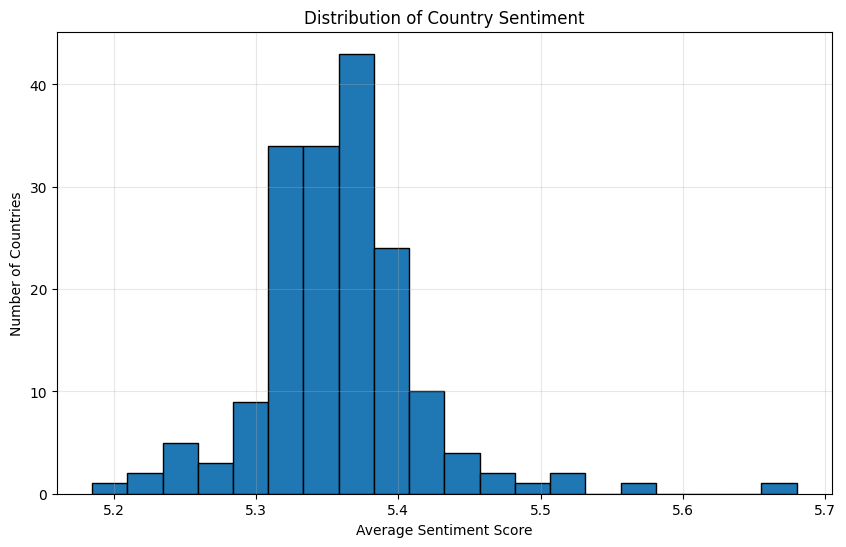

In [74]:
sentiment_values = [v for v in country_sentiments.values() if v is not None]
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(sentiment_values, bins=20, edgecolor='black')
plt.xlabel("Average Sentiment Score")
plt.ylabel("Number of Countries")
plt.title("Distribution of Country Sentiment")
plt.grid(alpha=0.3)
plt.show()
